In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download the inception v3 weights
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [3]:
# Create an instance of the inception model from the local pre-trained weights
# local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = '/mnt/external_data/inception_weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(include_top = False,
                               weights = None,
                               input_shape = (150, 150, 3))   # reference for pararameters: https://keras.io/applications/#inceptionv3

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
# John's alternative method (do NOT use. It messed stuff up)
# pre_trained_model.trainable = False
  
# Print the model summary
pre_trained_model.summary()

# Expected Output is extremely large, but should end with:

#batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
#__________________________________________________________________________________________________
#activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
#__________________________________________________________________________________________________
#mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
#                                                                 activation_276[0][0]             
#__________________________________________________________________________________________________
#concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
#                                                                 activation_280[0][0]             
#__________________________________________________________________________________________________
#activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
#__________________________________________________________________________________________________
#mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
#                                                                 mixed9_1[0][0]                   
#                                                                 concatenate_5[0][0]              
#                                                                 activation_281[0][0]             
#==================================================================================================
#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [5]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [6]:
from tensorflow.keras.optimizers import RMSprop


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)  

model = Model(inputs = pre_trained_model.input, outputs = x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [7]:
# # Get the Horse or Human dataset
# !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# # Get the Horse or Human Validation dataset
# !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

# # local_zip = '//tmp/horse-or-human.zip'
# local_zip = '/mnt/external_data/horse_or_human/horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/training')
# zip_ref.close()

# local_zip = '/mnt/external_data/horse_or_human/validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/validation')
# zip_ref.close()

local_zip = '/mnt/external_data/horse_or_human/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')

local_zip = '/mnt/external_data/horse_or_human/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [8]:
train_horses_dir = '/tmp/horse-or-human/horses/'
train_humans_dir = '/tmp/horse-or-human/humans/'
validation_horses_dir = '/tmp/validation-horse-or-human/horses/'
validation_humans_dir = '/tmp/validation-horse-or-human/humans/'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [9]:
# Define our example directories and files
train_dir = '/tmp/horse-or-human/'
validation_dir = '/tmp/validation-horse-or-human/'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale= 1. /255, 
                                   rotation_range= 40, 
                                   width_shift_range= .2, 
                                   height_shift_range= .2, 
                                   shear_range= .2, 
                                   zoom_range= .2, 
                                   horizontal_flip= True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1. /255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory = train_dir, 
                                                    batch_size = 20, 
                                                    target_size = (150, 150), 
                                                    class_mode = 'binary')     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(directory = validation_dir, 
                                                         batch_size = 20, 
                                                         target_size = (150, 150), 
                                                         class_mode = "binary")

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
class johns_mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('acc') > 0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True
            

# callbacks = myCallback()
callbacks = johns_mycallback()
history = model.fit_generator(generator = train_generator, steps_per_epoch= int(1027 / 20) + 1,
                              callbacks= [callbacks], 
                              validation_steps= 50,
                              epochs = 100, 
                              validation_data = validation_generator, 
                              verbose= 1)

# history = model.fit_generator(
#             train_generator,
#             validation_data = validation_generator,
#             steps_per_epoch = 100,
#             epochs = 100,
#             validation_steps = 50,
#             verbose = 1,
#             callbacks=[callbacks])

Epoch 1/100
52/52 [==============================] - 46s 892ms/step - loss: 0.2476 - acc: 0.9009 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 2/100
52/52 [==============================] - 44s 843ms/step - loss: 0.1046 - acc: 0.9559 - val_loss: 0.2424 - val_acc: 0.9443
Epoch 3/100
52/52 [==============================] - 43s 832ms/step - loss: 0.0630 - acc: 0.9694 - val_loss: 0.0590 - val_acc: 0.9798
Epoch 4/100
52/52 [==============================] - 45s 870ms/step - loss: 0.0559 - acc: 0.9798 - val_loss: 0.0219 - val_acc: 0.9960
Epoch 5/100
52/52 [==============================] - 43s 819ms/step - loss: 0.1108 - acc: 0.9663 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 6/100
52/52 [==============================] - 44s 839ms/step - loss: 0.0692 - acc: 0.9721 - val_loss: 0.0088 - val_acc: 0.9919
Epoch 7/100
52/52 [==============================] - 43s 829ms/step - loss: 0.0517 - acc: 0.9856 - val_loss: 0.1779 - val_acc: 0.9757
Epoch 8/100
52/52 [==============================] - 43s 830ms

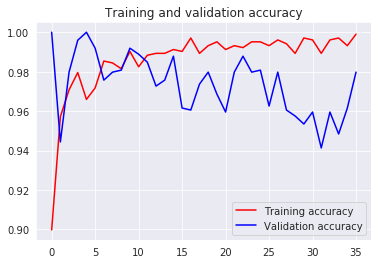

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

import seaborn as sns

sns.set_style('darkgrid')

epochs = range(len(acc))

# plt.fiture()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
# plt.figure()


plt.show()